# Подготовить данные для этапа моделирования (обучения)
1. Анализ данных, необходимые корректировки. 
2. Обработать пропуски. 
3. Оценить выбросы. 
4. Корреляция. 
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
7. Разделите данные на тренрровачную и тестовую выборку.
8. При обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import statistics 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("df_credit_train.csv", delimiter = ';', decimal= ',')

df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## Анализ данных и необходимые корректировки

In [2]:
#Поскольку столбец client_id является обозначением номера клиента и не несет в себе никакой больше информации, удаляем его
data_set = df.drop(df.columns[[0]], axis = 1)

# Отразим общую размерность нашего датасета, а так же общую информацию по кажжому из столбцов:
print("Размерность датасета составляет: {0} \n".format(data_set.shape))
data_set.info()

Размерность датасета составляет: (170746, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: f

Исходя из представленного выше, имеем следующее: в данном датасете 14 столбцов и 170746 строк. Поскольку количество ненулевых значений от столбца к столбцу разнится, в некоторых столбцах имеют место быть пропуски. А именно: age, marital_status, credit_sum, score_shk, education, living_region, monthly_income, credit_count, overdue_credit_count. Для каждого из столбцов пропуски будет обрабатывать отдельно.

In [3]:
#строки с пропусками в столбцах с категориальными данными - а именно living_region, education, marital_status - удалим. 
drop_columns = ['living_region', 'education', 'marital_status']

data_set.dropna(subset=drop_columns, inplace=True)

###  Обработка пропусков столбца с количественными данными
После удаления пропусков в столбцах с категориальными значениями, обработаем пропуски в столбцах с количественными значениями. Для этого сначала запустим отразим статистику по датасету. Исходя из этой статистики будет проводиться заполнение пропусков в тестовой и тренировочной выборках.

In [4]:
data_set.describe(exclude = 'object')

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,170546.000000,170546.000000,170547.000000,170544.000000,170546.000000,161335.000000,161335.000000,170547.000000
mean,36.499730,26093.569569,10.980955,0.469446,40136.867737,2.107534,0.046059,0.176233
std,10.547044,16233.140012,3.537229,0.124255,25046.744363,1.777370,0.211499,0.381019
min,18.000000,2736.000000,3.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,28.000000,14908.000000,10.000000,0.379495,25000.000000,1.000000,0.000000,0.000000
50%,34.000000,21229.000000,10.000000,0.461579,35000.000000,2.000000,0.000000,0.000000
75%,43.000000,32068.000000,12.000000,0.552366,50000.000000,3.000000,0.000000,0.000000
max,71.000000,200000.000000,36.000000,1.128291,950000.000000,21.000000,3.000000,1.000000


## Разбивка на тестовую и тренировочную выборки

In [5]:
train, test = train_test_split(data_set, test_size=0.3, random_state = 1)

#обновим индексы выборок
train.set_index(np.arange(len(train)), inplace=True)
test.set_index(np.arange(len(test)), inplace=True)

## Обработка пропусков столбца с количественными данными
#### 1) Обработка столбца age
Из статистики видно, что наименьшее и наибольшее значения корректны(нет отрицательных или невозможных значений, например возраст равный нулю). Исходя из этого пропуска считаем незаполненные данные(NAN), которые будем заполнять средними значениями

In [6]:
cleaned_train = train.copy(deep = True)
cleaned_test = test.copy(deep = True) 

cleaned_train["age"].fillna(cleaned_train["age"].mean(), inplace=True)
cleaned_test["age"].fillna(cleaned_test["age"].mean(), inplace=True)

#### 2) Обработка столбца credit_sum
Из статистики видно, что наименьшее и наибольшее значения корректны(нет отрицательных или невозможных значений, например возраст равный нулю). Исходя из этого пропуска считаем незаполненные данные(NAN), которые будем заполнять средними значениями

In [7]:
cleaned_train["credit_sum"].fillna(cleaned_train["credit_sum"].mean(), inplace=True)
cleaned_test["credit_sum"].fillna(cleaned_test["credit_sum"].mean(), inplace=True)

#### 3) Обработка столбца score_shk
Из статистики видно, что наименьшим значением в столбце является 0. Исходя из гипотезы, что этот столбец является отражением шкалы риска, считаем пропусками незаполненные ячейки и ячейки, равные нулю(при кредитовании точно нулевым риск быть не может).

In [8]:
#заполним пустые ячейки
cleaned_train["score_shk"].fillna(cleaned_train["score_shk"].mean(), inplace=True)
cleaned_test["score_shk"].fillna(cleaned_test["score_shk"].mean(), inplace=True)

#заполним нулевые ячейки средним значением
score_mean_train = statistics.median(cleaned_train["score_shk"])
score_mean_test = statistics.median(cleaned_test["score_shk"])

cleaned_train.loc[(cleaned_train["score_shk"] == 0), "score_shk"] = score_mean_train
cleaned_test.loc[(cleaned_test["score_shk"] == 0), "score_shk"] = score_mean_test

#### 4) Обработка столбца monthly_income
Из статистики видно, что наименьшее и наибольшее значения корректны(нет отрицательных или невозможных значений, например возраст равный нулю). Исходя из этого пропуска считаем незаполненные данные(NAN), которые будем заполнять средними значениями.

In [9]:
cleaned_train["monthly_income"].fillna(cleaned_train["monthly_income"].mean(), inplace=True)
cleaned_test["monthly_income"].fillna(cleaned_test["monthly_income"].mean(), inplace=True)

#### 5) Обработка столбца credit_count
Из статистики видно, что наименьшим значением в столбце является 0. Исходя из гипотезы, что этот столбец является отражением числа кредитов по работнику, считаем пропусками незаполненные ячейки и ячейки, равные нулю(если работник в этой таблице отражается, то у него должен быть как минимум один кредит). Пропуски заполняем модой по данному столбцу

In [10]:
cleaned_train["credit_count"].fillna(statistics.mode(cleaned_train["credit_count"]), inplace=True)
cleaned_test["credit_count"].fillna(statistics.mode(cleaned_test["credit_count"]), inplace=True)

mode_train = statistics.mode(cleaned_train["credit_count"])
mode_test = statistics.mode(cleaned_test["credit_count"])

cleaned_train.loc[(cleaned_train["credit_count"] == 0), "credit_count"] = mode_train
cleaned_test.loc[(cleaned_test["credit_count"] == 0), "credit_count"] = mode_test

#### 6) Обработка столбца overdue_credit_count
Из статистики видно, что наименьшее и наибольшее значения корректны(нет отрицательных или невозможных значений, поскольку количество просроченых кредитов вполне может быть равно нулю). Исходя из этого пропуска считаем незаполненные данные(NAN). Пропуски заполняем модой по данному столбцу

In [11]:
cleaned_train["overdue_credit_count"].fillna(statistics.mode(cleaned_train["overdue_credit_count"]), inplace=True)
cleaned_test["overdue_credit_count"].fillna(statistics.mode(cleaned_test["overdue_credit_count"]), inplace=True)

## Нормализируем данные
Нормализируем данные только по количественным признакам

In [14]:
normilized_columns = ["age", "credit_sum", "credit_month", "score_shk", "monthly_income"]

not_normilized_columns = list(data_set.columns)

for col in normilized_columns:
    not_normilized_columns.remove(col)
#регион будем обрабатывать отдельно   
train_region = cleaned_train['living_region'].copy()
test_region = cleaned_test['living_region'].copy()
not_normilized_columns.remove('living_region')

train_norm_copy = cleaned_train[normilized_columns].copy()
test_norm_copy = cleaned_test[normilized_columns].copy()

train_not_copy = cleaned_train[not_normilized_columns].copy()
test_not_copy = cleaned_test[not_normilized_columns].copy()

scaler = StandardScaler()

d = scaler.fit_transform(train_norm_copy)
train_norm_copy = pd.DataFrame(d, columns = normilized_columns)

d = scaler.fit_transform(test_norm_copy)
test_norm_copy = pd.DataFrame(d, columns = normilized_columns)

## Обработаем регионы, приведя их к обещму шаблону

In [15]:
#Список слов, от которых будем избавляться
trash_words = {"ОБЛ", "ОБЛАСТЬ", "РЕСП", "РЕСПУБЛИКА", "АО", "АОБЛ", "Г", "Г.", "Р-Н", "КРАЙ", 
               "РЕСП.", "АВТОНОМНЫЙ", "ФЕДЕРАЛЬНЫЙ", "ОКРУГ", "АВТОНОМНАЯ", "СЕВ", "СЕВЕРНАЯ"} 

train_living_region = train_region.tolist()
test_living_region = test_region.tolist()

def replacing_name(str):
    if str == 'РЕСПУБЛИКАТАТАРСТАН':
        str = 'РЕСПУБЛИКА ТАТАРСТАН'
    elif "98" in str:
        str = 'САНКТ-ПЕТЕРБУРГ'
    elif "74" in str:
        str = 'ЧЕЛЯБИНСКАЯ ОБЛ'
    elif "МОСКВОСКАЯ" in str:
        str = 'МОСКОВСКАЯ ОБЛ'
    elif "АЛТАЙСКИЙ" in str:
        str = 'АЛТАЙСКИЙ КРАЙ'
    elif "АРХАНГЕЛЬСКАЯ" in str:
        str = 'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ'
    elif "АСТРАХАНСКАЯ" in str:
        str = 'АСТРАХАНСКАЯ ОБЛАСТЬ'
    elif "АСТРАХАНСКАЯ" in str:
        str = 'АСТРАХАНСКАЯ ОБЛАСТЬ'
    elif "ВОЛОГОДСКАЯ" in str:
        str = 'ВОЛОГОДСКАЯ ОБЛАСТЬ'
    elif "БАШКОРТОСТАН" in str:
        str = 'РЕСПУБЛИКА БАШКОРТОСТАН'
    elif "БРЯНСКИЙ" in str:
        str = 'БРЯНСКИЙ РАЙОН'
    elif "БУРЯТИЯ" in str:
        str = 'РЕСПУБЛИКА БУРЯТИЯ'
    elif "МОСКВА" in str:
        str = 'МОСКВА'
    elif "САНКТ-ПЕТЕРБУРГ" in str:
        str = 'САНКТ-ПЕТЕРБУРГ'
    elif "ЕВРЕЙСКАЯ" in str:
        str = 'ЕВРЕЙСКАЯ ОБЛАСТЬ'
    elif "КАЛМЫКИЯ" in str:
        str = 'РЕСПУБЛИКА КАЛМЫКИЯ'
    elif "КАЛУЖСКАЯ" in str:
        str = 'КАЛУЖСКАЯ ОБЛАСТЬ'
    elif "КАРАЧАЕВО-ЧЕРКЕССКАЯ" in str:
        str = 'КАРАЧАЕВО-ЧЕРКЕССКАЯ ОБЛАСТЬ'
    elif "КАРЕЛИЯ" in str:
        str = 'РЕСПУБЛИКА КАРЕЛИЯ'
    elif "КАБАРДИНО-БАЛКАРСКАЯ" in str:
        str = 'КАБАРДИНО-БАЛКАРСКАЯ ОБЛАСТЬ'
    elif "КЕМЕРОВСКАЯ" in str:
        str = 'КЕМЕРОВСКАЯ ОБЛАСТЬ'
    elif "КОМИ" in str:
        str = 'РЕСПУБЛИКА КОМИ'
    elif "КРАСНОДАРСКИЙ" in str:
        str = 'КРАСНОДАРСКИЙ КРАЙ'
    elif "ЛЕНИНГРАДСКАЯ" in str:
        str = 'ЛЕНИНГРАДСКАЯ ОБЛАСТЬ'
    elif "МОСКОВСКАЯ" in str:
        str = 'МОСКОВСКАЯ ОБЛАСТЬ'
    elif "НОВОСИБИРСКАЯ" in str:
        str = 'НОВОСИБИРСКАЯ ОБЛАСТЬ'
    elif "ОМСКАЯ" in str:
        str = 'ОМСКАЯ ОБЛАСТЬ'
    elif "ПЕРМСКИЙ" in str:
        str = 'ПЕРМСКИЙ КРАЙ'
    elif "САХА" in str:
        str = 'РЕСПУБЛИКА САХА'
    elif "ЧУВАШСКАЯ" in str:
        str = 'РЕСПУБЛИКА ЧУВАШСКАЯ - ЧУВАШИЯ'
    elif "РОСТОВСКАЯ" in str:
        str = 'РОСТОВСКАЯ ОБЛАСТЬ'
    elif "САМАРСКАЯ" in str:
        str = 'САМАРСКАЯ ОБЛАСТЬ'
    elif "СВЕРДЛОВСКАЯ" in str:
        str = 'СВЕРДЛОВСКАЯ ОБЛАСТЬ'
    elif "ОСЕТИЯ" in str:
        str = 'РЕСПУБЛИКА ОСЕТИЯ - АЛАНИЯ'
    elif "СТАВРОПОЛЬСКИЙ" in str:
        str = 'СТАВРОПОЛЬСКИЙ КРАЙ'
    elif "ТЮМЕНСКАЯ" in str:
        str = 'ТЮМЕНСКАЯ ОБЛАСТЬ'
    elif "ХАКАСИЯ" in str:
        str = 'РЕСПУБЛИКА ХАКАСИЯ'
    elif "ХАНТЫ-МАНСИЙСКИЙ" in str:
        str = 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ'
    return str

def split_string(word):
    words = word.split(' ')
    new_words = []
    new_words= [i for i in words if not i in trash_words]
    buff = list(filter(None, new_words))
    word = ' '.join(buff)
    return word

def clean_string(word):
    word = replacing_name(word)
    word = word.upper()#большинство данных в столбце находятся в верхнем регистре, поэтому все приводим к общей форме
    word = re.sub('[\d+\t\r\n{}//.,!;?:]', ' ', word)
    if "ОБЛ" in word:
        word = split_string(word)
        word = word + " ОБЛАСТЬ"
    elif "РЕСП" in word:
        word = split_string(word)
        word = "РЕСПУБЛИКА " + word
    elif "АО" in word:
        word = split_string(word)
        word = word + " АВТОНОМНЫЙ ОКРУГ"
    elif "Р-Н" in word:
        word = split_string(word)
        word = word + " РАЙОН"
    elif "КРАЙ" in word:
        word = split_string(word)
        word = word + " КРАЙ"
    return word

train_counter = 0

for word in train_living_region:
    cleaned_word = clean_string(word)
    train_living_region[train_counter]= cleaned_word
    train_counter +=1

test_counter = 0
    
for word in test_living_region:
    cleaned_word = clean_string(word)
    test_living_region[test_counter]= cleaned_word
    test_counter +=1 

In [16]:
#соберем выборки вместе и оценим выбросы по каждой из них

normilized_train = pd.concat([train_norm_copy, train_not_copy], axis=1)
normilized_train.insert(loc= 10 , column='living_region', value=train_living_region)

normilized_test = pd.concat([test_norm_copy, test_not_copy], axis=1)
normilized_test.insert (loc= 10 , column='living_region', value=test_living_region)

## Определим выбросы по каждой из выборок

<AxesSubplot:>

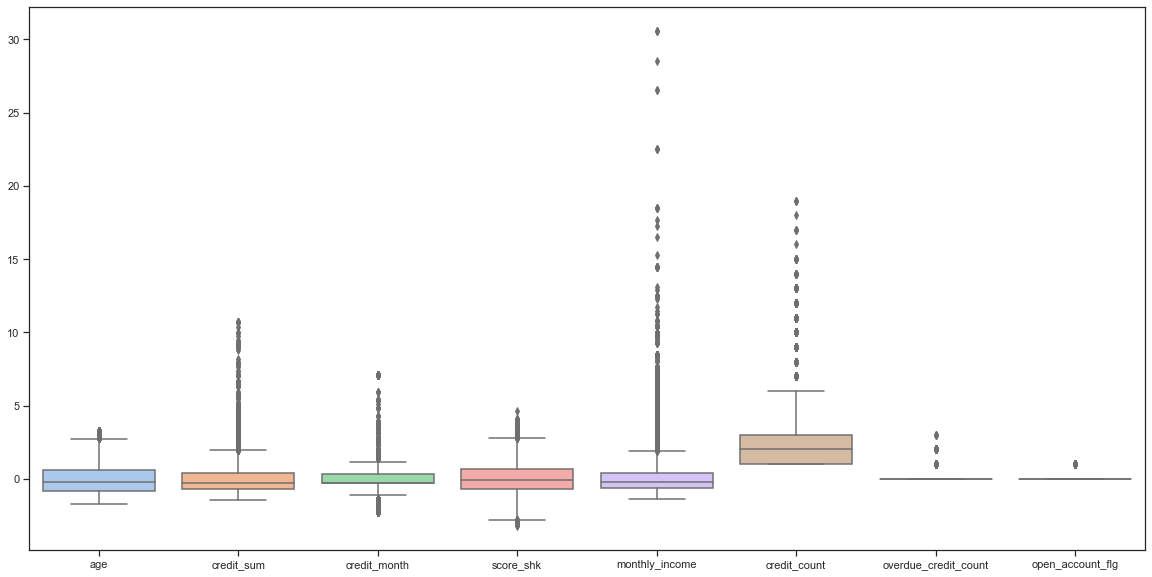

In [18]:
#выбросы по тренировочной выборке
sns.set_theme(style="ticks", palette="pastel")
plt.figure (figsize=(20,10))
sns.boxplot(data=normilized_train)

In [19]:
#удалим выбросы в тренировочной выборке

cleaned_columns = ["age", "credit_sum", "credit_month", "score_shk", "monthly_income", "credit_count", "overdue_credit_count"]

for col in cleaned_columns:
    Q_1 = normilized_train[col].quantile(q = 0.25)
    Q_3 = normilized_train[col].quantile(q = 0.75)
    IQR = Q_3 - Q_1
    normilized_train = normilized_train.loc[~((normilized_train[col] < (Q_1-1.5*IQR))|(normilized_train[col] > (Q_3+1.5*IQR)))]

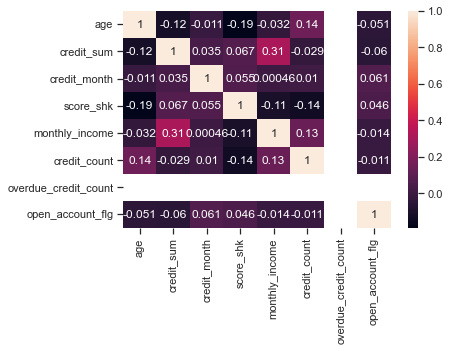

In [20]:
#сделаем матрицу корреляции по трнировочной выборке
corr_matrix = normilized_train.corr()
sns.heatmap(corr_matrix, annot=True);

In [21]:
from scipy.stats import normaltest

numberic_postions = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 
                     'overdue_credit_count','open_account_flg']
for pos in numberic_postions:
    print (pos,end=': ')
    if normaltest(normilized_train[pos].astype(np.float32).values).pvalue>0.05:
        print ("Распределение СООТВЕТСТВУЕТ нормальному")
    else:
        print ("Распределение НЕ СООТВЕТСТВУЕТ нормальному")

age: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_sum: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_month: Распределение НЕ СООТВЕТСТВУЕТ нормальному
tariff_id: Распределение НЕ СООТВЕТСТВУЕТ нормальному
score_shk: Распределение НЕ СООТВЕТСТВУЕТ нормальному
monthly_income: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
overdue_credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
open_account_flg: Распределение НЕ СООТВЕТСТВУЕТ нормальному


<AxesSubplot:>

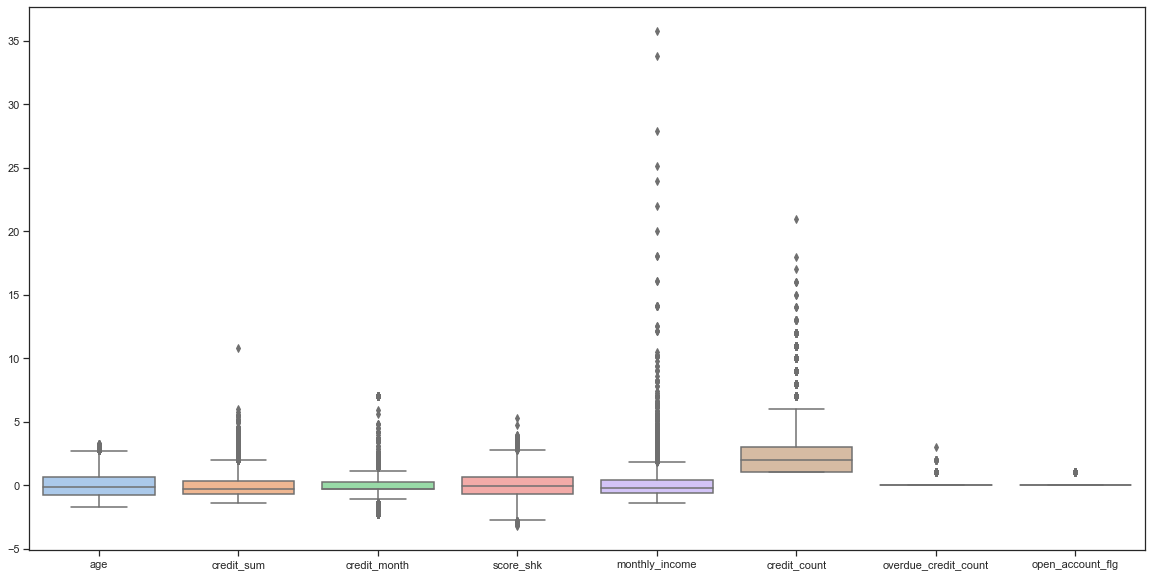

In [22]:
#выбросы по тестовой выборке
sns.set_theme(style="ticks", palette="pastel")
plt.figure (figsize=(20,10))
sns.boxplot (data=normilized_test)

In [23]:
#удалим выбросы в тестовой выборке

for col in cleaned_columns:
    Q_1 = normilized_train[col].quantile(q = 0.25)
    Q_3 = normilized_train[col].quantile(q = 0.75)
    IQR = Q_3 - Q_1
    normilized_test = normilized_test.loc[~((normilized_test[col] < (Q_1-1.5*IQR))|(normilized_test[col] > (Q_3+1.5*IQR)))]

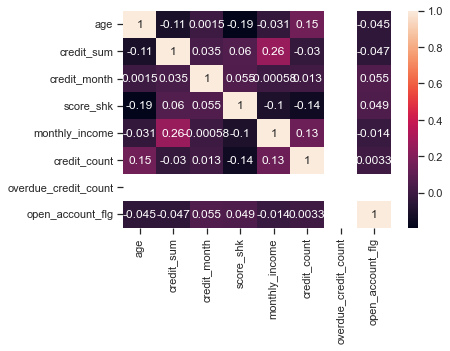

In [25]:
#сделаем матрицу корреляции по тестовой выборке
corr_matrix = normilized_test.corr()
sns.heatmap(corr_matrix, annot=True);

In [26]:
for pos in numberic_postions:
    print (pos,end=': ')
    if normaltest(normilized_test[pos].astype(np.float32).values).pvalue>0.05:
        print ("Распределение СООТВЕТСТВУЕТ нормальному")
    else:
        print ("Распределение НЕ СООТВЕТСТВУЕТ нормальному")

age: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_sum: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_month: Распределение НЕ СООТВЕТСТВУЕТ нормальному
tariff_id: Распределение НЕ СООТВЕТСТВУЕТ нормальному
score_shk: Распределение НЕ СООТВЕТСТВУЕТ нормальному
monthly_income: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
overdue_credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
open_account_flg: Распределение НЕ СООТВЕТСТВУЕТ нормальному
